In [2]:
from functools import reduce
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import unitary_group

import os, sys
module_path = os.path.abspath('../..')
if module_path not in sys.path:
    sys.path.append(module_path)

from unisys import gate
from unisys.utils import operations
from unisys import spam, decompose

rand_unitary = unitary_group.rvs


**Gate decomposition examples:**

- Fixed gate decomposition
  - SWAP 
  - CH
  - CCX
  - ...
- Universal gate decomposition
  - Tensor product decomposition
  - ABC decomposition (2-qubit controlled-U gate)
  - KAK decomposition (arbitrary 2-qubit gate)
  - Quantum Shannon decomposition (arbitrary unitary gate)
  - m-control n-target CU gate decomposition
- Continuous-variable unitary synthesis
  - Reck decomposition

**State preparation examples:**
- Arbitrary two-qubit state preparation
- Arbitrary three-qubit state preparation


## Gate Decomposition

### Fixed gate decomposition

#### SWAP gate

In [3]:
circ = decompose.swap_decompose(gate.SWAP.on([0, 1]))
print(circ)
circ.to_qiskit().draw()


Circuit(num_gates: 3, num_qubits: 2)


┌───┐     ┌───┐
q_0: ┤ X ├──■──┤ X ├
     └─┬─┘┌─┴─┐└─┬─┘
q_1: ──■──┤ X ├──■──
          └───┘

#### CH gate

In [4]:
circ = decompose.ch_decompose(gate.H.on(2, 1))
print(circ)
circ.to_qiskit().draw()


Circuit(num_gates: 7, num_qubits: 2)


q_0: ───────────────────────────────────────
                                            
q_1: ─────────────────■─────────────────────
     ┌───┐┌───┐┌───┐┌─┴─┐┌─────┐┌───┐┌─────┐
q_2: ┤ S ├┤ H ├┤ T ├┤ X ├┤ Tdg ├┤ H ├┤ Sdg ├
     └───┘└───┘└───┘└───┘└─────┘└───┘└─────┘

In [5]:
print(circ.to_qasm())


OPENQASM 2.0;
include "qelib1.inc";


// Qubits: [0, 1, 2]
qreg q[3];

// Quantum gate operations
s q[2];
h q[2];
t q[2];
cx q[1], q[2];
tdg q[2];
h q[2];
sdg q[2];



#### CCX gate

In [6]:
circ = decompose.ccx_decompose(gate.X.on([2], [0,1]))
print(circ)
circ.to_qiskit().draw()


Circuit(num_gates: 15, num_qubits: 3)


┌───┐      ┌───┐┌─────┐┌───┐
q_0: ───────■─────────────────────■───┤ T ├──────┤ X ├┤ Tdg ├┤ X ├
            │                     │   └───┘      └─┬─┘└┬───┬┘└─┬─┘
q_1: ───────┼───────────■─────────┼───────────■────■───┤ T ├───■──
     ┌───┐┌─┴─┐┌─────┐┌─┴─┐┌───┐┌─┴─┐┌─────┐┌─┴─┐┌───┐ ├───┤      
q_2: ┤ H ├┤ X ├┤ Tdg ├┤ X ├┤ T ├┤ X ├┤ Tdg ├┤ X ├┤ T ├─┤ H ├──────
     └───┘└───┘└─────┘└───┘└───┘└───┘└─────┘└───┘└───┘ └───┘

In [7]:
for i, g in enumerate(circ):
    print(i, g)

0 H{2}
1 X{2←0}
2 TDG{2}
3 X{2←1}
4 T{2}
5 X{2←0}
6 TDG{2}
7 X{2←1}
8 T{2}
9 T{0}
10 X{0←1}
11 H{2}
12 T{1}
13 TDG{0}
14 X{0←1}


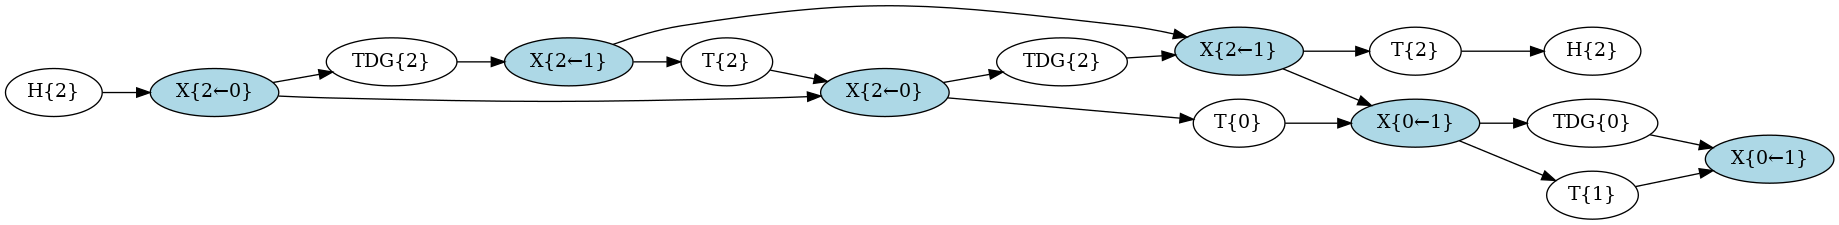

In [11]:
circ.draw_circ_dag_graphviz()

### Universal gate decomposition

#### Tensor product decomposition

**$X \otimes Y$ gate**

In [16]:
xy_prod = np.kron(gate.X.data, gate.Y.data)
g = gate.UnivGate(xy_prod, 'XY')
print(xy_prod)


[[0.+0.j 0.-0.j 0.+0.j 0.-1.j]
 [0.+0.j 0.+0.j 0.+1.j 0.+0.j]
 [0.+0.j 0.-1.j 0.+0.j 0.-0.j]
 [0.+1.j 0.+0.j 0.+0.j 0.+0.j]]


In [17]:
circ = decompose.tensor_product_decompose(g.on([0,1]))
circ.to_qiskit().draw()


┌────────────────┐
q_0: ┤ U3(π,π/2,-π/2) ├
     └─┬────────────┬─┘
q_1: ──┤ U3(π,π,-π) ├──
       └────────────┘

In [18]:
circ = decompose.tensor_product_decompose(g.on([1,0])) # permute the qubits
circ.to_qiskit().draw()


┌────────────┐  
q_0: ──┤ U3(π,π,-π) ├──
     ┌─┴────────────┴─┐
q_1: ┤ U3(π,π/2,-π/2) ├
     └────────────────┘

**$I\otimes U$ gate**

In [19]:
U = rand_unitary(2, random_state=123)
print('origin U3 paramters:', operations.params_u3(U)) # period of rotation angle is 2*pi


origin U3 paramters: (2.208653326893343, -5.085970328808669, 0.11715443835178085)


In [22]:
g = gate.UnivGate(np.kron(np.identity(2), U), 'IxU').on([0,1])
circ = decompose.tensor_product_decompose(g)
circ.to_qiskit().draw()


┌───────────┐        
q_0: ────────┤ U3(0,0,0) ├────────
     ┌───────┴───────────┴───────┐
q_1: ┤ U3(2.2087,1.1972,0.11715) ├
     └───────────────────────────┘

#### ABC decomposition

**$CRz(\theta)$ gate**

In [23]:
g = gate.RZ(0.12).on(1, 0)
circ = decompose.abc_decompose(g)
print('decomposition correct?:', operations.is_equiv_unitary(operations.controlled_unitary_matrix(g.data), circ.unitary()))
circ.to_qiskit().draw()


decomposition correct?: True


q_0: ──────────────■─────────────────■──
     ┌──────────┐┌─┴─┐┌───────────┐┌─┴─┐
q_1: ┤ Rz(0.06) ├┤ X ├┤ Rz(-0.06) ├┤ X ├
     └──────────┘└───┘└───────────┘└───┘

**$CU$ gate**

In [24]:
g = gate.UnivGate(rand_unitary(2, random_state=123), 'U').on(1, 0)
circ = decompose.abc_decompose(g)
print('decomposition correct?:', operations.is_equiv_unitary(operations.controlled_unitary_matrix(g.data), circ.unitary()))
circ.to_qiskit().draw()


decomposition correct?: True


┌────────────┐    
q_0: ────────────────■─────────────────────────────■───────┤ Rz(1.1469) ├────
     ┌────────────┐┌─┴─┐┌───────────────────────┐┌─┴─┐┌────┴────────────┴───┐
q_1: ┤ Rz(2.6016) ├┤ X ├┤ U3(1.1043,π,-0.65718) ├┤ X ├┤ U3(1.1043,1.1972,0) ├
     └────────────┘└───┘└───────────────────────┘└───┘└─────────────────────┘

#### KAK decomposition

Circuit(num_gates: 11, num_qubits: 2)
decomposition correct?: True


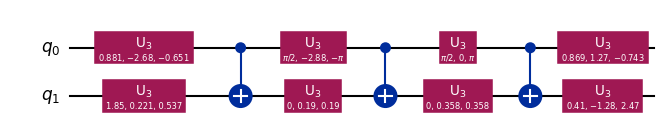

In [29]:
g = gate.UnivGate(rand_unitary(4, random_state=123), 'U').on([0, 1])
circ = decompose.kak_decompose(g)
print(circ)
print('decomposition correct?:', operations.is_equiv_unitary(g.data, circ.unitary()))
circ.to_qiskit().draw('mpl', scale=0.75)


#### Quantum Shannon decomposition

In [30]:
n = 4 # number of qubits
U = rand_unitary(2 ** n, random_state=123)
g = gate.UnivGate(U, 'U').on(list(range(n)))
circ = decompose.qs_decompose(g)
circ.to_qiskit().draw('mpl', filename='qs_decompose.png', scale=0.5)
print(circ)
print('number of CNOTs:', len([g for g in circ if isinstance(g, gate.XGate) and len(g.cqs) == 1 and len(g.tqs) == 1]))
print('decomposition correct?:', operations.is_equiv_unitary(g.data, circ.unitary()))


Circuit(num_gates: 412, num_qubits: 4)
number of CNOTs: 180
decomposition correct?: True


#### m-control n-target CU gate decomposition

In [41]:
cqs = [0, 2, 4, 5]  # arbitrary order is OK
tqs = [1, 6]
m = len(cqs)
n = len(tqs)
U = rand_unitary(2 ** n, random_state=123)
circ = decompose.cu_decompose(gate.UnivGate(U, 'U').on(tqs, cqs))
circ.to_qiskit().draw('mpl', filename='cu_decompose.png', scale=0.5)
print(circ)
print('number of CNOTs:', len([g for g in circ if isinstance(g, gate.XGate) and len(g.cqs) == 1 and len(g.tqs) == 1]))
print('decomposition correct?:', operations.is_equiv_unitary(
    operations.tensor_slots(operations.controlled_unitary_matrix(U, m), max(cqs + tqs) + 1, cqs + tqs),
    circ.unitary(with_dummy=True)  # herein set with_dummy=True to include dummy qubits
))


Circuit(num_gates: 632, num_qubits: 6)
number of CNOTs: 314
decomposition correct?: True


### Continuous-variable unitary synthesis

#### Reck decomposition

In [32]:
H3 = reduce(np.kron, [gate.H.data] * 3)
params_list, D = decompose.reck_decompose(H3)


In [33]:
print(D)


[1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j]


In [34]:
params_list


[(6, 7, 0.7853981633974476, 0, 8),
 (5, 7, 2.1862760354652835, 0, 8),
 (4, 7, 2.0943951023931953, 0, 8),
 (3, 7, 2.0344439357957027, 0, 8),
 (2, 7, 1.9913306620788616, 0, 8),
 (1, 7, 1.183199640139716, 0, 8),
 (0, 7, 1.209429202888189, 0, 8),
 (5, 6, 1.0471975511965954, 0, 8),
 (4, 6, 2.186276035465283, 0, 8),
 (3, 6, 1.1502619915109316, 0, 8),
 (2, 6, 2.0344439357957023, 0, 8),
 (1, 6, 1.9321634507016046, 0, 8),
 (0, 6, 1.183199640139716, 0, 8),
 (4, 5, -2.3561944901923466, 0, 8),
 (3, 5, 1.1831996401397158, 0, 8),
 (2, 5, 1.2094292028881897, 0, 8),
 (1, 5, 1.1071487177940909, 0, 8),
 (0, 5, 1.1502619915109311, 0, 8),
 (3, 4, 1.9321634507016048, 0, 8),
 (2, 4, 1.183199640139716, 0, 8),
 (1, 4, 1.9913306620788616, 0, 8),
 (0, 4, 1.1071487177940909, 0, 8),
 (2, 3, -2.3561944901923453, 0, 8),
 (1, 3, 0.9553166181245096, 0, 8),
 (0, 3, 1.0471975511965974, 0, 8),
 (1, 2, 2.0943951023931953, 0, 8),
 (0, 2, 0.9553166181245093, 0, 8),
 (0, 1, 0.7853981633974488, 0, 8)]

## State Preparation

### Arbitrary single-qubit state preparation

In [35]:
psi = np.array([1j, -2, -2 + 1j, 2 - 1j]) / np.sqrt(15)
circ = spam.arbitrary_2_qubit_state_circuit(psi, return_u3=True)
circ.to_qiskit().draw()


┌────────────────────────────┐                                   
q_0: ┤ U3(1.9106,-0.9273,-0.9273) ├─■─────────────────────────────────
     └─┬────────────────────────┬─┘ │ ┌──────────────────────────────┐
q_1: ──┤ U3(3π/4,1.8546,1.8546) ├───■─┤ U3(1.1326,-0.67474,-0.77141) ├
       └────────────────────────┘     └──────────────────────────────┘

In [36]:
print('global phase factor:', operations.times_two_matrix(circ.unitary() @ np.array([1, 0, 0, 0]), psi))


global phase factor: (-0.9792195562182054-0.2028030105413231j)


### Arbitrary two-qubit state preparation

In [23]:
# ...
